<a href="https://colab.research.google.com/github/rtjord/ece570-project/blob/main/ECE_570_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Tiny Reproduction of CutMix on CIFAR-100 and Tiny ImageNet

>[A Tiny Reproduction of CutMix on CIFAR-100 and Tiny ImageNet](#scrollTo=pGH7Z0hfEAtY)

>[Overview](#scrollTo=Qqcd8t6G7fmR)

>>[What you’ll do](#scrollTo=Qqcd8t6G7fmR)

>>[Outputs & visuals](#scrollTo=Qqcd8t6G7fmR)

>>[Run order (per dataset)](#scrollTo=Qqcd8t6G7fmR)

>[Runtime Setup](#scrollTo=Fl4iaIoSETEz)

>>[Set Up File Directory](#scrollTo=4zb6uHYTGawp)

>>[Set Seed](#scrollTo=4URjJlVfGmKh)

>>[Print Device Info and Package Versions](#scrollTo=zV1SAaGiG1Xk)

>[Global Config](#scrollTo=ZXU4toqzB1NZ)

>[Core Utilities](#scrollTo=IEoTzlq7wBZn)

>>[Get Device](#scrollTo=Z2yIwlSWHrRN)

>>[Top-k Accuracy](#scrollTo=IsBaFXILH3YQ)

>>[Confusion Matrix](#scrollTo=D-G9SsS8IIgN)

>[Load Data](#scrollTo=5dzCEj2jusP6)

>>[Make Transforms](#scrollTo=wlwgTPZLIVDf)

>>[CIFAR-100 Data Loaders](#scrollTo=DPX6N4KUJIux)

>>[Download Tiny ImageNet](#scrollTo=-9t303LUJwBC)

>>[Construct Tiny ImageNet Validation](#scrollTo=wbRB1FwlKQfD)

>>[Tiny ImageNet Data Loaders](#scrollTo=WZTDt77PKdEW)

>[Build ResNet-18 Model](#scrollTo=w6WhObE6vh5B)

>[Train Model](#scrollTo=6GdW2IhbvtSt)

>>[Optimizer](#scrollTo=p4dYupy7MPaX)

>>[Freeze / Unfreeze Weights](#scrollTo=d18t4njcL6mX)

>>[Cosine Warm-up](#scrollTo=8225xnk4M6Js)

>>[Soft Categorical Cross-Entropy](#scrollTo=06Y2AhjzO98A)

>>[Plotting Helper](#scrollTo=ub-tpV1hPVU2)

>>[Base Training Loop](#scrollTo=LfO7wYCjOW4e)

>>[Linear Probe](#scrollTo=eUJeDnlhLpMk)

>>[Fine Tune](#scrollTo=pDpqPRWsMrZY)

>[Evaluate Model](#scrollTo=m2jQXMHEvvjc)

>[Visualize Results](#scrollTo=cku7UWgXwOSn)

>[Run Linear Probe](#scrollTo=QwRymXJyE9vO)

>[Run Experiment](#scrollTo=RUA1Ycgj1hS5)

>[CIFAR-100 Experiments](#scrollTo=119xYLjkFQhC)

>>[Linear Probe](#scrollTo=Polo5up_FLYb)

>>[Baseline](#scrollTo=053-lvam1kUF)

>>[Cutout](#scrollTo=IyMuTHTQCNO6)

>>[MixUp](#scrollTo=Tv-QUfHu9wCZ)

>>[CutMix](#scrollTo=Ft9_i0T49uRm)

>[Tiny ImageNet Experiments](#scrollTo=FZjvvYroFpBh)

>>[Linear Probe](#scrollTo=0w3fjzvCFuRQ)

>>[Baseline](#scrollTo=Ddt8Gj7k8Plf)

>>[Cutout](#scrollTo=rmH6Wp23Ca1Z)

>>[MixUp](#scrollTo=e9Y80pGNkehE)

>>[CutMix](#scrollTo=_oGl1HoIkiFq)

>[Comparison](#scrollTo=dC2pUTymlNXU)



# Overview

**Goal:** Trains and evaluate a single ResNet-18 on two datasets with shared code, clear stats, and useful visuals.

## What you’ll do
- **Load & explore data (no transforms):** dataset sizes, class names, quick image grids.
- **Show base transforms:** preview train/eval pipelines (resize/crop/normalize).
- **Visualize MixUp & CutMix:** see how each augmentation alters a batch.
- **Build the model:** load ImageNet-pretrained ResNet-18; swap the head to match classes (100 for CIFAR-100, 200 for Tiny ImageNet).
- **Train in two phases per dataset:**
  1) **Linear probe** (train head only) → log loss, Top-1/Top-5, time; plot curves  
  2) **Full fine-tune** (unfreeze all) → log/plot metrics again
- **Test & analyze:** final test loss/Top-1/Top-5, confusion matrix, a few example predictions.
- **Compare results:** compact table (CIFAR-100 vs Tiny ImageNet) and a small bar chart.

## Outputs & visuals
- Dataset stats (sizes, per-class counts, channel means/stds)
- Image grids (raw + transformed)
- MixUp & CutMix montages
- Training curves (loss, Top-1)
- Final confusion matrix per dataset
- Summary table across datasets

## Run order (per dataset)
1. **Data loading → stats → raw visuals**  
2. **Transform previews (train/eval)**  
3. **MixUp/CutMix visualization**  
4. **Model build (pretrained) + head swap**  
5. **Linear probe training + metrics/plots**  
6. **Full fine-tune + metrics/plots**  
7. **Test evaluation + confusion matrix + examples**

> **Tip:** Use a **GPU runtime** in Colab (`Runtime → Change runtime type → GPU`) for reasonable training speed.


# Runtime Setup

## Set Up File Directory

In [ ]:
import os, random, platform
from pathlib import Path
import numpy as np
import torch
import torchvision
import matplotlib

# ---- Base paths ----
BASE_DIR = Path("./")
DATA_DIR = BASE_DIR / "data"
RUNS_DIR = BASE_DIR / "runs"
CKPT_DIR = RUNS_DIR / "checkpoints"
FIG_DIR = RUNS_DIR / "figs"
for d in [DATA_DIR, RUNS_DIR, CKPT_DIR, FIG_DIR]:
    d.mkdir(parents=True, exist_ok=True)


## Set Seed



In [ ]:
SEED = 42
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # Determinism vs speed: keep benchmark=True for speed on fixed-size images
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

set_seed(SEED)

## Print Device Info and Package Versions

In [ ]:
import torch
import torchvision
import matplotlib
import platform

# ---- Device info ----
if torch.cuda.is_available():
    device = torch.device("cuda")
    props = torch.cuda.get_device_properties(0)
    cc = f"{props.major}.{props.minor}"
    print(f"Device: CUDA — {torch.cuda.get_device_name(0)} (cc {cc})")
    print(f"GPU RAM: {props.total_memory/1e9:.2f} GB")
else:
    device = torch.device("cpu")
    print("Device: CPU")

# ---- Versions ----
print(f"PyTorch:     {torch.__version__} (CUDA {torch.version.cuda})")
print(f"Torchvision: {torchvision.__version__}")
print(f"Matplotlib:  {matplotlib.__version__}")
print(f"Python:      {platform.python_version()}")

# ---- Paths summary ----
print(f"DATA_DIR = {DATA_DIR}")
print(f"CKPT_DIR = {CKPT_DIR}")
print(f"FIG_DIR  = {FIG_DIR}")

Device: CUDA — NVIDIA A100-SXM4-80GB (cc 8.0)
GPU RAM: 85.17 GB
PyTorch:     2.8.0+cu126 (CUDA 12.6)
Torchvision: 0.23.0+cu126
Matplotlib:  3.10.0
Python:      3.12.12
DATA_DIR = data
CKPT_DIR = runs/checkpoints
FIG_DIR  = runs/figs


# Global Config
Keep these hyperparameters the same between experiments.

In [ ]:
import torch

# Minimal, tweakable configuration for both datasets
CONFIG = {
    "batch_size": 256 if torch.cuda.is_available() else 64,  # bigger if GPU
    "workers": 4,                 # set to 0 if you see DataLoader worker issues in Colab
    "image_size": 224,            # ResNet-18 default input size
    "scratch_epochs": 300,         # Number of epochs when training from scratch
    "scratch_lr": 0.1,            # Learning rate when training from scratch
    "scratch_momentum": 0.9,
    "scratch_weight_decay": 1e-4,
    "lp_epochs": 20,              # linear probe (train head only)
    "ft_epochs": 30,              # full fine-tune (unfreeze all)
    "ft_warmup_epochs": 5,        # learning rate gradually increases in these epochs
    "lp_lr": 1e-2,                # learning rate for linear probe
    "ft_lr": 1e-3,                # learning rate for fine-tuning
    "weight_decay": 5e-4,         # L2 regularization
    "use_amp": torch.cuda.is_available(),  # automatic mixed precision on GPU
    "seed": 42,
}

# Core Utilities

## Get Device

In [ ]:
import torch

def get_device():
    """Prefer CUDA, then Apple MPS, else CPU."""
    if torch.cuda.is_available():
        return torch.device("cuda")
    if getattr(torch.backends, "mps", None) and torch.backends.mps.is_available():
        return torch.device("mps")
    return torch.device("cpu")

## Top-k Accuracy

In [ ]:
import torch

def topk_accuracy(logits: torch.Tensor, targets: torch.Tensor, ks=(1, 5)):
    """Return dict {k: top-k %}. Clamps k to #classes."""
    with torch.no_grad():
        B, C = logits.shape
        maxk = min(max(ks), C)
        _, pred = logits.topk(maxk, dim=1)           # [B,maxk]
        pred = pred.t()                               # [maxk,B]
        correct = pred.eq(targets.view(1, -1).expand_as(pred))
        return {int(k): (correct[:min(k,C)].reshape(-1).float().sum().item() * 100.0 / B) for k in ks}

## Confusion Matrix

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt


def confusion_matrix(y_true, y_pred, num_classes: int):
    """Compute counts confusion matrix (numpy) with rows=true, cols=pred."""
    yt = torch.as_tensor(y_true).view(-1).cpu().numpy()
    yp = torch.as_tensor(y_pred).view(-1).cpu().numpy()
    cm = np.zeros((num_classes, num_classes), dtype=np.int64)
    np.add.at(cm, (yt, yp), 1)
    return cm

def plot_confusion_matrix(cm: np.ndarray, class_names=None, normalize: bool = True, figsize=(6,6)):
    """Plot confusion matrix; normalized by true class rows if normalize=True."""
    M = cm.astype(np.float64)
    if normalize:
        row_sums = M.sum(axis=1, keepdims=True)
        M = np.divide(M, row_sums, out=np.zeros_like(M), where=row_sums != 0)
        vmin, vmax = 0.0, 1.0
    else:
        vmin, vmax = None, None
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(M, cmap="Blues", vmin=vmin, vmax=vmax)
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title("Confusion Matrix" + (" (normalized)" if normalize else ""))
    if class_names is not None:
        ticks = np.arange(len(class_names))
        ax.set_xticks(ticks); ax.set_xticklabels(class_names, rotation=90)
        ax.set_yticks(ticks); ax.set_yticklabels(class_names)
    fig.tight_layout()
    return fig, ax

# Load Data

## Make Transforms

In [ ]:
from torchvision import transforms, models

IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

def make_transforms(image_size: int = 224, train: bool = True):
    """
    Construct image preprocessing transforms for ResNet-18 training and evaluation.

    Parameters
    ----------
    image_size : int, default=224
        Target spatial size of images. For training, this defines the crop size used
        by ``RandomResizedCrop``. For evaluation, the ResNet-18 pretrained weights'
        default preprocessing (resize to 256, center crop to 224) is used.
    train : bool, default=True
        If True, return augmentation pipeline for training data:
        random resized crop, random horizontal flip, tensor conversion,
        and ImageNet normalization. If False, return the official
        preprocessing transform attached to ``ResNet18_Weights.IMAGENET1K_V1``.

    Returns
    -------
    transform : torchvision.transforms.Compose or callable
        A transformation pipeline that maps a PIL Image (or Tensor) to a normalized
        Tensor suitable for ResNet-18 input.
    """
    if train:
        return transforms.Compose([
            transforms.RandomResizedCrop(image_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
        ])
    else:
        weights = models.ResNet18_Weights.IMAGENET1K_V1
        return weights.transforms()

## CIFAR-100 Data Loaders

In [ ]:
from pathlib import Path
import torch
from torch.utils.data import DataLoader, random_split, Dataset, Subset
from torchvision import datasets
from typing import Tuple, List


def build_cifar100_loaders(
    cfg: dict,
    root: str | Path = "./data",
    val_split: float = 0.1,
) -> Tuple[DataLoader, DataLoader, DataLoader, List[str]]:
    """
    Build CIFAR-100 train/val/test loaders such that:
      - Train uses **train** transforms (augmentations).
      - Val uses the **same transforms as Test** (eval transforms).
      - The val split is deterministic and **indices are preserved** across
        the two train datasets (aug vs eval).

    Parameters
    ----------
    cfg : dict
        Expected keys:
          - 'batch_size' (int, default 256)
          - 'workers' (int, default 2)
          - 'image_size' (int, default 224)
          - 'seed' (int, default 42)
    root : str or Path, default "./data"
        Dataset root.
    val_split : float, default 0.1
        Fraction of CIFAR-100 train set reserved for validation.

    Returns
    -------
    train_loader : torch.utils.data.DataLoader
        Loader over the training subset with train-time transforms.
    val_loader : torch.utils.data.DataLoader
        Loader over the validation subset with **eval** transforms (same as test).
    test_loader : torch.utils.data.DataLoader
        Loader over the test split with eval transforms.
    class_names : list[str]
        CIFAR-100 class names.
    """
    root = Path(root)
    bs   = int(cfg.get("batch_size", 256))
    nw   = int(cfg.get("workers", 2))
    img  = int(cfg.get("image_size", 224))
    seed = int(cfg.get("seed", 42))
    pin  = torch.cuda.is_available()

    # Per-sample transforms
    tf_train = make_transforms(img, train=True)   # augments + ImageNet norm
    tf_eval  = make_transforms(img, train=False)  # built-in eval transform

    # Two logically identical train datasets, differing only by transform
    train_ds_aug  = datasets.CIFAR100(root=str(root), train=True,  download=True,  transform=tf_train)
    train_ds_eval = datasets.CIFAR100(root=str(root), train=True,  download=False, transform=tf_eval)
    test_ds       = datasets.CIFAR100(root=str(root), train=False, download=True,  transform=tf_eval)

    class_names = list(train_ds_aug.classes)

    # Deterministic split on indices (shared across both train datasets)
    n_total = len(train_ds_aug)
    n_val   = int(round(n_total * float(val_split)))
    n_train = n_total - n_val

    # random_split returns Subset objects; we only need their indices
    g = torch.Generator().manual_seed(seed)
    train_subset_idx, val_subset_idx = random_split(range(n_total), [n_train, n_val], generator=g)
    train_idx = list(train_subset_idx.indices)
    val_idx   = list(val_subset_idx.indices)

    # Subset with appropriate transforms
    train_subset = Subset(train_ds_aug,  train_idx)  # aug pipeline
    val_subset   = Subset(train_ds_eval, val_idx)    # eval pipeline (SAME as test)

    # DataLoaders
    train_loader = DataLoader(train_subset, batch_size=bs, shuffle=True,  num_workers=nw, pin_memory=pin)
    val_loader   = DataLoader(val_subset,   batch_size=bs, shuffle=False, num_workers=nw, pin_memory=pin)
    test_loader  = DataLoader(test_ds,      batch_size=bs, shuffle=False, num_workers=nw, pin_memory=pin)

    return train_loader, val_loader, test_loader, class_names

## Download Tiny ImageNet

In [ ]:
from pathlib import Path
import subprocess

def ensure_tinyimagenet(root: str | Path = "./data") -> Path:
    """
    Ensure Tiny ImageNet is present under root.
    Downloads and unzips into root/tiny-imagenet-200 if missing.
    """
    root = Path(root)
    target_dir = root / "tiny-imagenet-200"
    zip_path = root / "tiny-imagenet-200.zip"

    if not target_dir.exists():
        root.mkdir(parents=True, exist_ok=True)

        # Download if zip not already there
        if not zip_path.exists():
            print("Downloading Tiny ImageNet...")
            subprocess.run(
                ["wget", "http://cs231n.stanford.edu/tiny-imagenet-200.zip", "-O", str(zip_path)],
                check=True
            )

        # Unzip into root
        print("Unzipping Tiny ImageNet...")
        print(zip_path)
        subprocess.run(["unzip", str(zip_path), "-d", str(root)], check=True)

    return target_dir

## Construct Tiny ImageNet Validation

In [ ]:
from pathlib import Path
import os
import subprocess
from typing import Optional
import torch
from torch.utils.data import DataLoader, random_split, Dataset, Subset
from torchvision import transforms, models
from PIL import Image


# --- Tiny ImageNet helpers ---

class TinyImageNetVal(Dataset):
    """
    Tiny-ImageNet 'val' folder uses a CSV-style annotation file instead of class subfolders.
    This dataset reads 'val_annotations.txt' and maps each image to the corresponding wnid.
    Expects the standard layout:
      root/
        train/<wnid>/*.JPEG
        val/images/*.JPEG
        val/val_annotations.txt  (filename, wnid, x, y, w, h ...)
        wnids.txt (optional)
    """
    def __init__(self, root: str | Path, transform=None, class_to_idx: Optional[dict] = None):
        self.root = Path(root)
        self.transform = transform
        anno_path = self.root / "val" / "val_annotations.txt"
        images_dir = self.root / "val" / "images"

        # Build class_to_idx from train if not given
        if class_to_idx is None:
            train_dir = self.root / "train"
            wnids = sorted([d.name for d in train_dir.iterdir() if d.is_dir()])
            class_to_idx = {wnid: i for i, wnid in enumerate(wnids)}
        self.class_to_idx = class_to_idx

        # Parse annotations
        self.samples = []  # list of (image_path, target_idx)
        with open(anno_path, "r") as f:
            for line in f:
                parts = line.strip().split("\t")
                if len(parts) < 2:
                    parts = line.strip().split()  # fallback on whitespace
                fname, wnid = parts[0], parts[1]
                if wnid not in self.class_to_idx:
                    # If class not in mapping (shouldn't happen), skip
                    continue
                img_path = images_dir / fname
                self.samples.append((img_path, self.class_to_idx[wnid]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, target = self.samples[idx]
        img = Image.open(path).convert("RGB")
        if self.transform is not None:
            img = self.transform(img)
        return img, target

## Tiny ImageNet Data Loaders

In [ ]:
from pathlib import Path
from torch.utils.data import DataLoader, random_split, Dataset, Subset
from torchvision import datasets, transforms


def build_tinyimagenet_loaders(
    cfg: dict,
    root: str | Path = "./data",
) -> Tuple[DataLoader, DataLoader, DataLoader, List[str]]:
    """
    Returns train_loader, val_loader, test_loader, class_names for Tiny ImageNet.
    - train: ImageFolder(root/train)
    - val: uses TinyImageNetVal (annotation file) OR ImageFolder if already reorganized
    - test: labels are not provided in the official release; we reuse 'val' as 'test' for metrics.
    """
    root = Path(root)
    ensure_tinyimagenet(root)
    bs = int(cfg.get("batch_size", 256))
    nw = int(cfg.get("workers", 2))
    img_sz = int(cfg.get("image_size", 224))
    pin = torch.cuda.is_available()

    tf_train = make_transforms(img_sz, train=True)
    tf_eval  = make_transforms(img_sz, train=False)

    train_dir = root / "tiny-imagenet-200" / "train"

    # Train via ImageFolder
    train_set = datasets.ImageFolder(str(train_dir), transform=tf_train)
    assert len(train_set.classes) == 200, f"Expected 200 train classes, got {len(train_set.classes)}"
    class_names = list(train_set.classes)  # wnids

    # Validation set with labels
    val_full = TinyImageNetVal(
        root / "tiny-imagenet-200",
        transform=tf_eval,
        class_to_idx=train_set.class_to_idx
    )

    # Split val_full into validation and test
    val_size = int(0.5 * len(val_full))   # e.g. 5k val / 5k test
    test_size = len(val_full) - val_size
    val_set, test_set = random_split(val_full, [val_size, test_size])

    # DataLoaders
    train_loader = DataLoader(train_set, batch_size=bs, shuffle=True,
                              num_workers=nw, pin_memory=pin)
    val_loader   = DataLoader(val_set, batch_size=bs, shuffle=False,
                              num_workers=nw, pin_memory=pin)
    test_loader  = DataLoader(test_set, batch_size=bs, shuffle=False,
                              num_workers=nw, pin_memory=pin)

    # No labeled test set officially; we reuse val as test for evaluation.
    test_loader  = val_loader
    return train_loader, val_loader, test_loader, class_names

# Build ResNet-18 Model

In [ ]:
def build_resnet18(num_classes, pretrained=True):
    """
    Build a ResNet-18 replace the head to `num_classes`.
    """
    if pretrained:
        model = torchvision.models.resnet50(weights="IMAGENET1K_V1")
    else:
        model = torchvision.models.resnet50(weights=None)  # random init

    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

# Train Model

## Optimizer

In [ ]:
from torch import optim

def make_discriminative_optimizer(model, lr_backbone=3e-4, lr_head=3e-3, weight_decay=5e-4, momentum=0.9, nesterov=True):
    """Two param groups: smaller LR for backbone, larger for head."""
    backbone, head = [], []
    for n, p in model.named_parameters():
        if not p.requires_grad:
            continue
        (head if n.startswith("fc.") else backbone).append(p)
    return optim.SGD(
        [{"params": backbone, "lr": lr_backbone},
         {"params": head,     "lr": lr_head}],
        momentum=momentum, weight_decay=weight_decay, nesterov=nesterov
    )

## Freeze / Unfreeze Weights

In [ ]:
from torch import nn

def freeze_backbone_bn_eval(model):
    """Freeze all params except final fc; set BN layers to eval for a stable linear probe."""
    for n, p in model.named_parameters():
        p.requires_grad = n.startswith("fc.")
    for m in model.modules():
        if isinstance(m, nn.modules.batchnorm._BatchNorm):
            m.eval()

def unfreeze_all(model):
    """Enable training for all params (fine-tuning)."""
    for p in model.parameters():
        p.requires_grad = True
    model.train()  # BN back to train

## Cosine Warm-up

In [ ]:
from torch import optim

def make_warmup_cosine(optimizer, warmup_epochs: int, total_epochs: int):
    """Linear warmup then cosine annealing over the remaining epochs."""
    warmup_epochs = max(0, int(warmup_epochs))
    total_epochs = max(1, int(total_epochs))
    if warmup_epochs >= total_epochs:
        # fallback: pure cosine with T_max at least 1
        return optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max(1, total_epochs))
    warm = optim.lr_scheduler.LinearLR(optimizer, start_factor=0.1, total_iters=warmup_epochs)
    cos  = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max(1, total_epochs - warmup_epochs))
    return optim.lr_scheduler.SequentialLR(optimizer, [warm, cos], milestones=[warmup_epochs])

## Soft Categorical Cross-Entropy

In [ ]:
from torch import nn

class SoftCE(nn.Module):
    def forward(self, logits, targets):
        if targets.dtype in (torch.long, torch.int64):  # hard labels
            return nn.functional.cross_entropy(logits, targets)
        logp = nn.functional.log_softmax(logits, dim=-1)
        return -(targets * logp).sum(dim=-1).mean()

## Plotting Helper

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_curves(history: dict, title: str):
    """Plot train loss and val top-1 from a History dict."""
    if not history or "train_loss" not in history:
        print("Nothing to plot.")
        return
    xs = np.arange(1, len(history["train_loss"]) + 1)
    fig, ax1 = plt.subplots()
    ax1.plot(xs, history["train_loss"], label="train_loss")
    ax1.plot(xs, history.get("val_loss", []), label="val_loss")
    ax1.set_xlabel("epoch"); ax1.set_ylabel("loss"); ax1.grid(True, alpha=0.3)
    ax2 = ax1.twinx()
    if "val_top1" in history:
        ax2.plot(xs, history["val_top1"], "o--", label="val_top1", alpha=0.7)
        ax2.set_ylabel("Top-1 (%)")
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc="best")
    plt.title(title)
    plt.savefig(FIG_DIR / f"{title}.png")
    plt.show()

## Base Training Loop

In [ ]:
import math
import torch
from torch import nn, optim

def train_one_epoch(
    model,
    loader,
    optimizer,
    device=None,
    batch_aug=None,         # callable: (images, targets) -> (images, targets); e.g., v2.MixUp/CutMix
    amp=True,               # automatic mixed precision on CUDA
    criterion=None,         # supports soft labels if using MixUp/CutMix
):
    """One training epoch. Returns average loss."""
    device = device or get_device()
    model.train()
    criterion = criterion or SoftCE()

    scaler = torch.amp.GradScaler(
        device="cuda",
        enabled=(amp and device.type == "cuda")
    )
    running_loss, seen = 0.0, 0

    for x, y in loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)

        if batch_aug is not None:
            x, y = batch_aug(x, y)  # may return soft targets

        optimizer.zero_grad(set_to_none=True)
        with torch.autocast(device_type=device.type, enabled=(amp and device.type in {"cuda", "mps"})):
            logits = model(x)
            loss = criterion(logits, y)

        if scaler.is_enabled():
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

        bs = y.size(0)
        running_loss += loss.item() * bs
        seen += bs

    return running_loss / max(1, seen)

## Linear Probe

In [ ]:
import math
import numpy as np
import torch
from torch import nn, optim
import matplotlib.pyplot as plt


def run_linear_probe(
    model,
    train_loader,
    val_loader,
    device,
    epochs=3,
    lr=1e-2,
    weight_decay=5e-4,
    batch_aug=None,
    amp=True,
    verbose=True
):
    """Train only the new head; BN layers kept in eval mode."""
    freeze_backbone_bn_eval(model)
    optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()),
                          lr=lr, momentum=0.9, weight_decay=weight_decay, nesterov=True)
    criterion = SoftCE()

    history = {"train_loss": [], "val_loss": [], "val_top1": [], "val_top5": [], "lr": []}
    for epoch in range(1, epochs + 1):
        train_loss = train_one_epoch(model, train_loader, optimizer, device,
                                     batch_aug=batch_aug, amp=amp, criterion=criterion)
        val = evaluate(model, val_loader, device)
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val["loss"])
        history["val_top1"].append(val["top1"])
        history["val_top5"].append(val["top5"])
        history["lr"].append([pg["lr"] for pg in optimizer.param_groups])
        if verbose:
            print(f"[LP] epoch {epoch:02d}  train_loss={train_loss:.4f}  "
                  f"val_loss={val['loss']:.4f}  top1={val['top1']:.2f}%  top5={val['top5']:.2f}%  lr={[pg["lr"] for pg in optimizer.param_groups]}")
    return history

## Fine Tune

In [ ]:
import torch
from google.colab import files

def run_fine_tune(
    name,
    model,
    train_loader,
    val_loader,
    device,
    epochs=10,
    lr_backbone=3e-4,
    lr_head=3e-3,
    weight_decay=5e-4,
    warmup_epochs=1,
    batch_aug=None,
    amp=True,
    verbose=True
):
    """Unfreeze everything and train with discriminative LRs + warmup+cosine schedule."""
    unfreeze_all(model)
    optimizer = make_discriminative_optimizer(model, lr_backbone, lr_head, weight_decay)

    scheduler = make_warmup_cosine(optimizer, warmup_epochs=warmup_epochs, total_epochs=epochs)
    criterion = SoftCE()

    history = {"train_loss": [], "val_loss": [], "val_top1": [], "val_top5": [], "lr": []}

    best_val_loss = math.inf
    best_payload = None

    for epoch in range(1, epochs + 1):
        train_loss = train_one_epoch(model,
                                     train_loader,
                                     optimizer,
                                     device,
                                     batch_aug=batch_aug,
                                     amp=amp,
                                     criterion=criterion)

        val = evaluate(model, val_loader, device)
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val["loss"])
        history["val_top1"].append(val["top1"])
        history["val_top5"].append(val["top5"])
        history["lr"].append([pg["lr"] for pg in optimizer.param_groups])

        if verbose:
            print(f"[FT] epoch {epoch:02d}  train_loss={train_loss:.4f}  "
                  f"val_loss={val['loss']:.4f}  top1={val['top1']:.2f}%  top5={val['top5']:.2f}%  lr={[g['lr'] for g in optimizer.param_groups]}")

        if val["loss"] < best_val_loss:
            best_payload = {
                  "epoch": epoch,
                  "val_loss": float(val["loss"]),
                  "model_state": model.state_dict(),
                  "optimizer_state": optimizer.state_dict(),
              }

        scheduler.step()

    torch.save(best_payload, CKPT_DIR / f"{name}_best.pt")
    files.download(CKPT_DIR / f"{name}_best.pt")

    return history

## From Scratch

In [ ]:
def run_from_scratch(
    name,
    model,
    train_loader,
    val_loader,
    device,
    epochs,
    lr,
    weight_decay=1e-4,
    batch_aug=None,
):
    optimizer = torch.optim.SGD(
        model.parameters(),
        lr=lr,
        momentum=0.9,
        weight_decay=5e-4,
        nesterov=True,
    )

    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[int(0.5*epochs), int(0.75*epochs)], gamma=0.1)

    history = {"val_top1": [], "val_top5": [], "train_loss": [], "val_loss": []}

    best_val_loss = math.inf
    best_payload = None

    for epoch in range(epochs):
        train_loss = train_one_epoch(
            model,
            train_loader,
            optimizer,
            device=device,
            batch_aug=batch_aug,
            amp=True,
        )

        val_metrics = evaluate(model, val_loader, device=device)
        val_loss = val_metrics["loss"]
        top1 = val_metrics["top1"]
        top5 = val_metrics["top5"]

        if val_loss < best_val_loss:
            best_payload = {
                  "epoch": epoch,
                  "val_loss": float(val_metrics["loss"]),
                  "model_state": model.state_dict(),
                  "optimizer_state": optimizer.state_dict(),
            }
            torch.save(best_payload, CKPT_DIR / f"{name}_best.pt")

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["val_top1"].append(top1)
        history["val_top5"].append(top5)

        print(
            f"[Scratch] epoch {epoch+1:03d} "
            f"train_loss={train_loss:.4f}  val_loss={val_loss:.4f}  "
            f"top1={top1:.2f}%  top5={top5:.2f}%  "
            f"lr={scheduler.get_last_lr()[0]}"
        )
        scheduler.step()

    return history

# Evaluate Model

In [ ]:
def evaluate(model, loader, device=None, criterion=None, max_batches=None):
    """Eval with hard labels (no batch-level aug). Returns dict: loss/top1/top5."""
    device = device or get_device()
    model.eval()
    criterion = criterion or nn.CrossEntropyLoss()

    total, loss_sum, top1_sum, top5_sum = 0, 0.0, 0.0, 0.0
    with torch.no_grad():
        for b, (x, y) in enumerate(loader):
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss_sum += criterion(logits, y).item() * y.size(0)
            total += y.size(0)

            # Top-1 / Top-5
            pred1 = logits.argmax(dim=1)
            top1_sum += (pred1 == y).sum().item()
            k = min(5, logits.size(1))
            pred5 = logits.topk(k, dim=1).indices
            top5_sum += (pred5 == y.view(-1, 1)).any(dim=1).sum().item()

            # Limit number of batches used for evaluation
            if max_batches is not None and (b + 1) >= max_batches:
                break

    return {
        "loss": loss_sum / max(1, total),
        "top1": 100.0 * top1_sum / max(1, total),
        "top5": 100.0 * top5_sum / max(1, total),
    }

# Run Linear Probe

In [ ]:
def run_and_save_linear_probe(
    name,
    build_loaders_fn,
    num_classes: int,
    cfg: dict,
    loader_kwargs: dict | None = None,
    epochs: int = 20,
    lr: float = 1e-1,        # head-only, no wd
    weight_decay: float = 0.0,
    ckpt_path: str = "lp_base.pt",
):

    # Set seed for reproducibility
    set_seed(cfg.get("seed", 42))
    device = get_device()
    loader_kwargs = loader_kwargs or {}

    # Data loaders
    train_loader, val_loader, test_loader, _ = build_loaders_fn(cfg, **loader_kwargs)

    # Model
    model = build_resnet18(num_classes=num_classes).to(device)

    print("\n--- Linear probe ---")
    lp_hist = run_linear_probe(
        model,
        train_loader=train_loader,
        val_loader=val_loader,
        device=device,
        epochs=epochs,
        lr=lr,
        weight_decay=weight_decay,
        batch_aug=None,
        amp=bool(cfg.get("use_amp", torch.cuda.is_available())),
        verbose=True
    )
    torch.save(model.state_dict(), ckpt_path)
    plot_curves(lp_hist, title=f"{name} — Linear Probe")

    files.download(ckpt_path)
    print(f"Saved LP checkpoint to: {ckpt_path}")
    return ckpt_path

# Run Experiment

In [ ]:
import time
import torch
from torch import nn
import numpy as np
from torchvision.transforms import v2 as T2


def make_batch_aug(num_classes: int, mode: str = "none", p=0.5):
    m = (mode or "none").lower()
    if m in ("none", "off"):
      return None
    if m == "mixup":
        return T2.RandomApply(nn.ModuleList([T2.MixUp(num_classes=num_classes, alpha=1.0)]), p=p)
    if m == "cutmix":
        return T2.RandomApply(nn.ModuleList([T2.CutMix(num_classes=num_classes, alpha=1.0)]), p=p)
    if m == "cutout":
        return T2.RandomErasing(
            p=p,  # Original cutout paper suggests this approach when region is constrained within the image region
            scale=(0.25, 0.25),  # Mimic the CutMix paper's cutout implementation
            ratio=(1.0, 1.0),
            value=0.0,
            inplace=True,
        )
    raise ValueError("mix mode must be one of: 'none', 'mixup', 'cutmix', cutout")


def run_experiment(
    name: str,
    build_loaders_fn,
    num_classes: int,
    cfg: dict,
    aug_mode: str = "none",
    aug_prob: float = 0.5,
    ckpt_path: str | None = None,
    pretrained: bool = True
):
    """
    Returns:
      {
        'name': ...,
        'sizes': {'train': N, 'val': M, 'test': K},
        'class_counts': {'train': [...], 'val': [...], 'test': [...]},  # may be large; basic counts only
        'lp_history': {...},
        'ft_history': {...},
        'test_metrics': {'loss': ..., 'top1': ..., 'top5': ...},
        'cm': numpy.ndarray,   # confusion matrix (counts)
      }
    """
    set_seed(cfg.get("seed"))  # important for reproducibility
    device = get_device()

    # build data loaders
    train_loader, val_loader, test_loader, class_names = build_loaders_fn(cfg)

    print("\n--- Dataset stats ---")
    sizes = {
        "train": len(train_loader.dataset),
        "val":   len(val_loader.dataset),
        "test":  len(test_loader.dataset),
    }
    print(sizes)

    batch_aug = make_batch_aug(num_classes, aug_mode, p=aug_prob)
    model = build_resnet18(num_classes=num_classes,pretrained=pretrained).to(device)

    if not pretrained:
        hist = run_from_scratch(
            name,
            model,
            train_loader,
            val_loader,
            device=device,
            epochs=CONFIG["scratch_epochs"],
            lr=CONFIG["scratch_lr"],
            weight_decay=CONFIG["scratch_weight_decay"],
            batch_aug=batch_aug,
        )
        plot_curves(hist, title=f"{name} — From Scratch")
    else:
        # Load weights from linear probe checkpoint
        if ckpt_path is not None:
          checkpoint = torch.load(ckpt_path)
          model.load_state_dict(checkpoint)

        # ---- Fine-tune ----
        print("\n--- Fine-tune ---")
        lr_head = float(cfg.get("ft_lr"))
        lr_backbone = lr_head * 0.1
        hist = run_fine_tune(
            name,
            model,
            train_loader=train_loader,
            val_loader=val_loader,
            device=device,
            epochs=int(cfg.get("ft_epochs")),
            lr_backbone=lr_backbone,
            lr_head=lr_head,
            weight_decay=float(cfg.get("weight_decay")),
            warmup_epochs=cfg.get("ft_warmup_epochs"),
            batch_aug=batch_aug,
            amp=bool(cfg.get("use_amp", torch.cuda.is_available())),
            verbose=True,
        )
        plot_curves(hist, title=f"{name} — Fine-tune")

    # ---- Test ----
    print("\n--- Test ---")
    # Load weights from the epoch with lowest validation loss
    best_model_checkpoint = torch.load(CKPT_DIR / f"{name}_best.pt")
    model.load_state_dict(best_model_checkpoint["model_state"])

    test_metrics = evaluate(model, test_loader, device=device)
    print(f"{name} Test — loss={test_metrics['loss']:.4f}  top1={test_metrics['top1']:.2f}%  top5={test_metrics['top5']:.2f}%")

    # Confusion matrix (counts)
    y_true, y_pred = [], []
    model.eval()
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            logits = model(x)
            pred = logits.argmax(1).cpu()
            y_true.append(y)
            y_pred.append(pred)
    y_true = torch.cat([t if isinstance(t, torch.Tensor) else torch.tensor(t) for t in y_true]).cpu()
    y_pred = torch.cat([t if isinstance(t, torch.Tensor) else torch.tensor(t) for t in y_pred]).cpu()
    cm = confusion_matrix(y_true, y_pred, num_classes=num_classes)

    results = {
        "name": name,
        "sizes": sizes,
        "history": hist,
        "test_metrics": test_metrics,
        "cm": cm
    }
    return results


# CIFAR-100 Experiments

## Linear Probe


--- Linear probe ---
[LP] epoch 01  train_loss=3.7581  val_loss=2.6958  top1=38.54%  top5=70.02%  lr=[0.01]
[LP] epoch 02  train_loss=2.9554  val_loss=2.2532  top1=44.54%  top5=76.06%  lr=[0.01]
[LP] epoch 03  train_loss=2.7354  val_loss=2.0751  top1=46.76%  top5=78.68%  lr=[0.01]
[LP] epoch 04  train_loss=2.6258  val_loss=1.9950  top1=48.44%  top5=79.22%  lr=[0.01]
[LP] epoch 05  train_loss=2.5714  val_loss=1.9192  top1=50.52%  top5=80.40%  lr=[0.01]


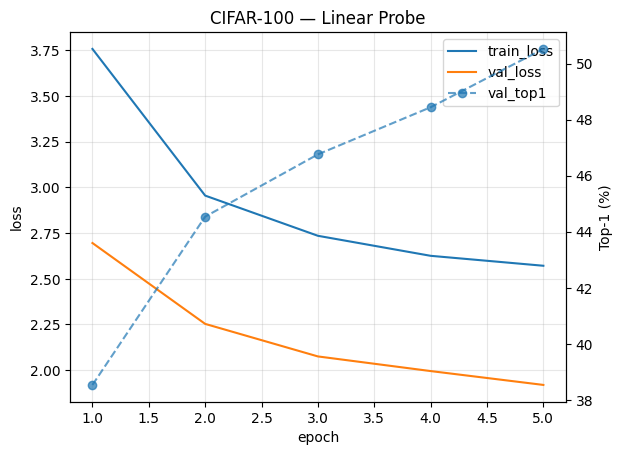

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saved LP checkpoint to: runs/checkpoints/cifar100_lp.pt


PosixPath('runs/checkpoints/cifar100_lp.pt')

In [ ]:
run_and_save_linear_probe(
    "CIFAR-100",
    build_cifar100_loaders,
    num_classes=100,
    cfg=CONFIG,
    epochs=CONFIG.get("lp_epochs"),
    lr=CONFIG.get("lp_lr"),
    weight_decay=CONFIG.get("weight_decay"),
    ckpt_path=CKPT_DIR / "cifar100_lp.pt"
)


## Baseline


--- Dataset stats ---
{'train': 45000, 'val': 5000, 'test': 10000}

--- Build model ---
Model built: ResNet-18 -> 100 classes

--- Fine-tune ---
FT optimizer initial lrs: [0.0001, 0.001]
[FT] epoch 01  train_loss=2.4803  val_loss=1.8417  top1=52.36%  top5=81.78%  lr=[1e-05, 0.0001]


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


[FT] epoch 02  train_loss=2.3527  val_loss=1.6777  top1=55.84%  top5=84.16%  lr=[5.5e-05, 0.00055]
[FT] epoch 03  train_loss=2.2060  val_loss=1.5194  top1=58.04%  top5=87.10%  lr=[0.0001, 0.001]
[FT] epoch 04  train_loss=2.0932  val_loss=1.4572  top1=59.50%  top5=88.36%  lr=[7.500000000000001e-05, 0.00075]
[FT] epoch 05  train_loss=2.0478  val_loss=1.4268  top1=60.14%  top5=88.86%  lr=[2.5000000000000015e-05, 0.0002500000000000001]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

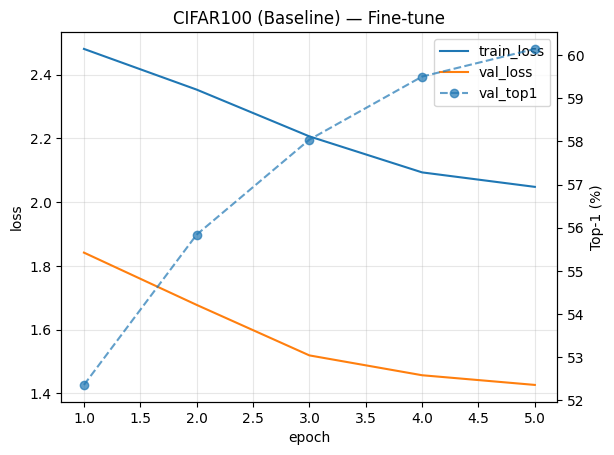


--- Test ---
CIFAR100 (Baseline) Test — loss=1.4447  top1=60.30%  top5=87.94%


In [ ]:
cifar_baseline = run_experiment("CIFAR100 (Baseline)",
                                  build_cifar100_loaders,
                                  num_classes=100,
                                  aug_mode="none",
                                  cfg=CONFIG,
                                  ckpt_path=CKPT_DIR / "cifar100_lp.pt")

## Cutout


--- Dataset stats ---
{'train': 45000, 'val': 5000, 'test': 10000}

--- Build model ---
Model built: ResNet-18 -> 100 classes

--- Fine-tune ---


/tmp/ipython-input-2634277791.py:20: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(amp and device.type == "cuda"))


[FT] epoch 01  train_loss=3.1786  val_loss=2.4574  top1=42.66%  top5=74.56%


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

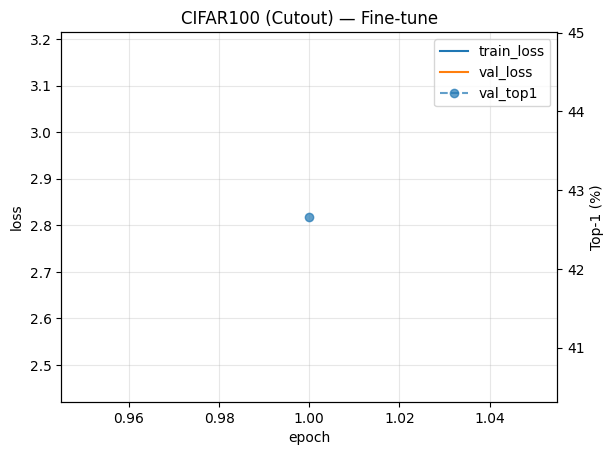


--- Test ---
CIFAR100 (Cutout) Test — loss=2.4918  top1=42.39%  top5=74.61%
Computing confusion matrix on test set...
Confusion matrix complete.


In [ ]:
cifar_cutout = run_experiment("CIFAR100 (Cutout)",
                                  build_cifar100_loaders,
                                  num_classes=100,
                                  aug_mode="cutout",
                                  cfg=CONFIG,
                                  ckpt_path=CKPT_DIR / "cifar100_lp.pt")

## MixUp


--- Dataset stats ---
{'train': 45000, 'val': 5000, 'test': 10000}

--- Build model ---
Model built: ResNet-18 -> 100 classes

--- Fine-tune ---


/tmp/ipython-input-2634277791.py:20: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(amp and device.type == "cuda"))


[FT] epoch 01  train_loss=3.6667  val_loss=2.5808  top1=40.26%  top5=72.00%


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

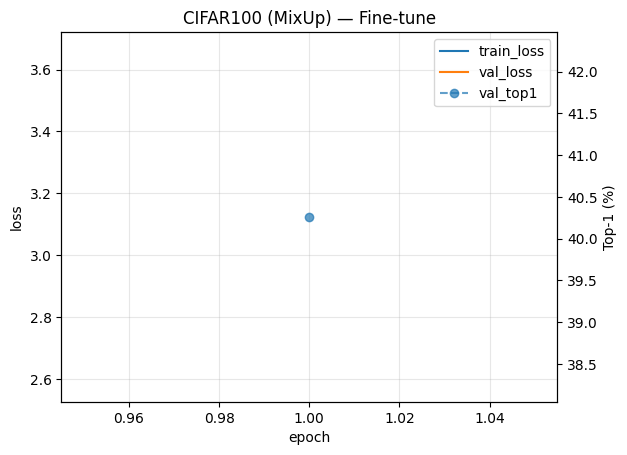


--- Test ---
CIFAR100 (MixUp) Test — loss=2.6253  top1=39.53%  top5=71.39%
Computing confusion matrix on test set...
Confusion matrix complete.


In [ ]:
cifar_mixup = run_experiment("CIFAR100 (MixUp)",
                                  build_cifar100_loaders,
                                  num_classes=100,
                                  aug_mode="mixup",
                                  cfg=CONFIG,
                                  ckpt_path=CKPT_DIR / "cifar100_lp.pt")

## CutMix


--- Dataset stats ---
{'train': 45000, 'val': 5000, 'test': 10000}

--- Build model ---
Model built: ResNet-18 -> 100 classes

--- Fine-tune ---


/tmp/ipython-input-2634277791.py:20: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(amp and device.type == "cuda"))


[FT] epoch 01  train_loss=3.7692  val_loss=2.6204  top1=39.50%  top5=72.18%


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

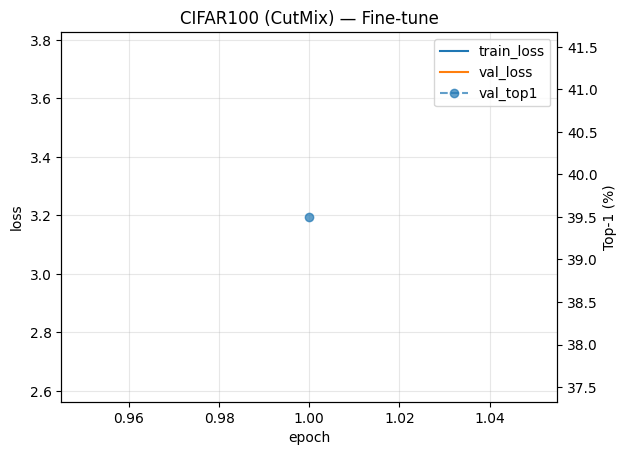


--- Test ---
CIFAR100 (CutMix) Test — loss=2.6575  top1=39.26%  top5=71.98%
Computing confusion matrix on test set...
Confusion matrix complete.


In [ ]:
cifar_cutmix = run_experiment("CIFAR100 (CutMix)",
                                  build_cifar100_loaders,
                                  num_classes=100,
                                  aug_mode="cutmix",
                                  cfg=CONFIG,
                                  ckpt_path=CKPT_DIR / "cifar100_lp.pt")

## Baseline from scratch

In [ ]:
GLOBAL_CONFIG = {
    "workers": 4,
    "image_size": 224,
    "momentum": 0.9,
    "nesterov": True,
    "weight_decay": 5e-4,
    "batch_size": 256,
    "use_amp": True,
    "seed": 42,
}

TRANSFER_CONFIG = GLOBAL_CONFIG | {
    "model": "resnet18",
    "pretrained": True,
    "aug": None,
    "aug_prob": 0.5,
    "lp_epochs": 20,
    "lp_lr": 1e-2,
    "ft_epochs": 30,
    "ft_warmup_epochs": 5,
    "ft_lr": 1e-3,
}

SCRATCH_CONFIG = GLOBAL_CONFIG | {
    "model": "resnet50",
    "pretrained": False,
    "aug": None,
    "aug_prob": 0.5,
    "epochs": 300,
    "lr": 0.1,
}


for aug in [None, "cutout", "mixup", "cutmix"]:
    cfg = TRANSFER_CONFIG | {"aug": aug, "ckpt_path": CKPT_DIR / ""}
    print(cfg)

for aug in [None, "cutout", "mixup", "cutmix"]:
    cfg = SCRATCH_CONFIG | {"aug": aug}
    print(cfg)

{'workers': 4, 'image_size': 224, 'momentum': 0.9, 'nesterov': True, 'weight_decay': 0.0005, 'batch_size': 256, 'use_amp': True, 'seed': 42, 'model': 'resnet18', 'pretrained': True, 'aug': None, 'aug_prob': 0.5, 'lp_epochs': 20, 'lp_lr': 0.01, 'ft_epochs': 30, 'ft_warmup_epochs': 5, 'ft_lr': 0.001}
{'workers': 4, 'image_size': 224, 'momentum': 0.9, 'nesterov': True, 'weight_decay': 0.0005, 'batch_size': 256, 'use_amp': True, 'seed': 42, 'model': 'resnet18', 'pretrained': True, 'aug': 'cutout', 'aug_prob': 0.5, 'lp_epochs': 20, 'lp_lr': 0.01, 'ft_epochs': 30, 'ft_warmup_epochs': 5, 'ft_lr': 0.001}
{'workers': 4, 'image_size': 224, 'momentum': 0.9, 'nesterov': True, 'weight_decay': 0.0005, 'batch_size': 256, 'use_amp': True, 'seed': 42, 'model': 'resnet18', 'pretrained': True, 'aug': 'mixup', 'aug_prob': 0.5, 'lp_epochs': 20, 'lp_lr': 0.01, 'ft_epochs': 30, 'ft_warmup_epochs': 5, 'ft_lr': 0.001}
{'workers': 4, 'image_size': 224, 'momentum': 0.9, 'nesterov': True, 'weight_decay': 0.0005, 


--- Dataset stats ---
{'train': 45000, 'val': 5000, 'test': 10000}
[Scratch] epoch 001 train_loss=5.1191  val_loss=4.5946  top1=1.84%  top5=6.22%  lr=0.1
[Scratch] epoch 002 train_loss=4.5016  val_loss=4.3798  top1=3.74%  top5=14.76%  lr=0.1
[Scratch] epoch 003 train_loss=4.2484  val_loss=4.1031  top1=5.80%  top5=22.22%  lr=0.1
[Scratch] epoch 004 train_loss=4.0578  val_loss=3.9259  top1=8.72%  top5=28.64%  lr=0.1
[Scratch] epoch 005 train_loss=3.9091  val_loss=3.7633  top1=11.34%  top5=34.08%  lr=0.1
[Scratch] epoch 006 train_loss=3.8008  val_loss=3.6870  top1=13.02%  top5=37.84%  lr=0.1
[Scratch] epoch 007 train_loss=3.6915  val_loss=3.4990  top1=16.14%  top5=42.44%  lr=0.1
[Scratch] epoch 008 train_loss=3.5733  val_loss=3.3631  top1=19.04%  top5=44.76%  lr=0.1
[Scratch] epoch 009 train_loss=3.4337  val_loss=3.2018  top1=21.64%  top5=49.88%  lr=0.1
[Scratch] epoch 010 train_loss=3.2916  val_loss=3.0800  top1=23.52%  top5=53.50%  lr=0.1
[Scratch] epoch 011 train_loss=3.1349  val_loss

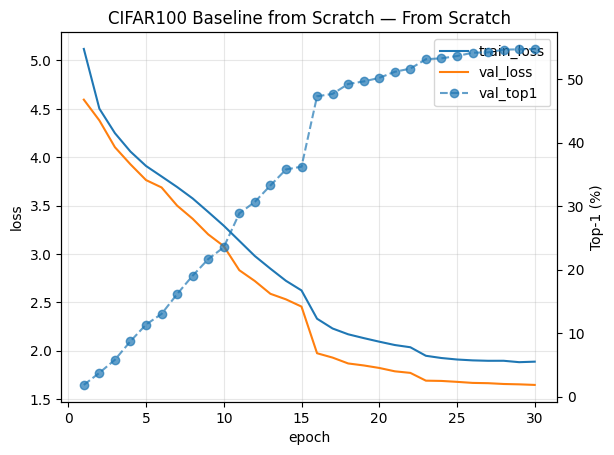


--- Test ---
CIFAR100 Baseline from Scratch Test — loss=1.6441  top1=55.14%  top5=83.61%


In [ ]:
cifar_baseline_scratch = run_experiment(
    "CIFAR100 Baseline from Scratch",
    build_cifar100_loaders,
    num_classes=100,
    aug_mode="none",
    cfg=CONFIG,
    ckpt_path=None,
    pretrained=False
)



--- Dataset stats ---
{'train': 45000, 'val': 5000, 'test': 10000}
[Scratch] epoch 001 train_loss=4.9717  val_loss=4.5517  top1=1.58%  top5=8.66%  lr=0.1
[Scratch] epoch 002 train_loss=4.4389  val_loss=4.2526  top1=4.56%  top5=18.60%  lr=0.1
[Scratch] epoch 003 train_loss=4.2939  val_loss=4.0573  top1=6.66%  top5=24.30%  lr=0.1
[Scratch] epoch 004 train_loss=4.1679  val_loss=3.9140  top1=9.08%  top5=30.36%  lr=0.1
[Scratch] epoch 005 train_loss=4.0620  val_loss=3.7423  top1=11.80%  top5=34.28%  lr=0.1
[Scratch] epoch 006 train_loss=3.9527  val_loss=3.7291  top1=14.22%  top5=38.90%  lr=0.1
[Scratch] epoch 007 train_loss=3.8726  val_loss=3.4861  top1=16.50%  top5=44.38%  lr=0.1
[Scratch] epoch 008 train_loss=3.7816  val_loss=3.3169  top1=19.56%  top5=49.16%  lr=0.1
[Scratch] epoch 009 train_loss=3.6280  val_loss=3.1295  top1=24.62%  top5=53.62%  lr=0.1
[Scratch] epoch 010 train_loss=3.6031  val_loss=3.0151  top1=25.68%  top5=55.60%  lr=0.1
[Scratch] epoch 011 train_loss=3.4745  val_loss

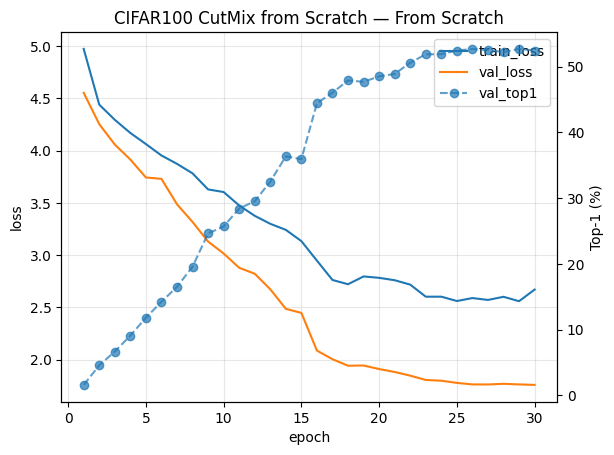


--- Test ---
CIFAR100 CutMix from Scratch Test — loss=1.7453  top1=53.23%  top5=82.33%


In [ ]:
cifar_cutmix_scratch = run_experiment(
    "CIFAR100 CutMix from Scratch",
    build_cifar100_loaders,
    num_classes=100,
    aug_mode="cutmix",
    aug_prob=0.5,
    cfg=CONFIG,
    ckpt_path=None,
    pretrained=False,
)

# Tiny ImageNet Experiments

## Linear Probe

In [ ]:
run_and_save_linear_probe(
    "CIFAR-100",
    build_tinyimagenet_loaders,
    num_classes=200,
    cfg=CONFIG,
    epochs=CONFIG.get("lp_epochs"),
    lr=CONFIG.get("lp_lr"),
    weight_decay=5e-4,
    ckpt_path=CKPT_DIR / "tiny_lp.pt"
)

Unzipping Tiny ImageNet...
data/tiny-imagenet-200.zip

--- Linear probe ---


/tmp/ipython-input-2634277791.py:20: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(amp and device.type == "cuda"))


[LP] epoch 01  train_loss=4.1357  val_loss=3.0754  top1=36.98%  top5=63.54%


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saved LP checkpoint to: runs/checkpoints/tiny_lp.pt


PosixPath('runs/checkpoints/tiny_lp.pt')

## Baseline


--- Dataset stats ---
{'train': 100000, 'val': 5000, 'test': 5000}

--- Build model ---
Model built: ResNet-18 -> 200 classes

--- Fine-tune ---


/tmp/ipython-input-2634277791.py:20: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(amp and device.type == "cuda"))


[FT] epoch 01  train_loss=3.0543  val_loss=2.2921  top1=50.34%  top5=77.48%


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

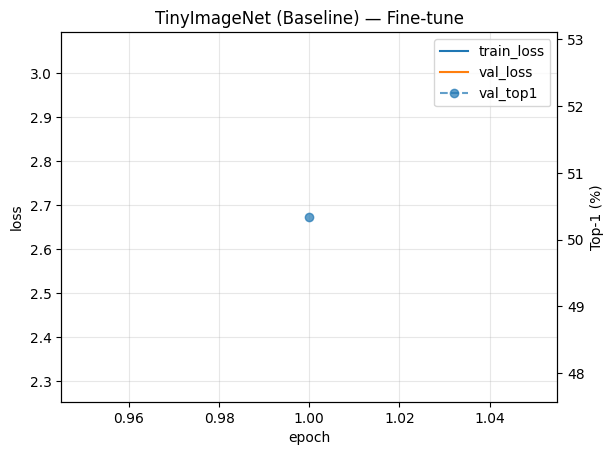


--- Test ---
TinyImageNet (Baseline) Test — loss=2.2921  top1=50.34%  top5=77.48%
Computing confusion matrix on test set...
Confusion matrix complete.


In [ ]:
tiny_baseline = run_experiment(
    "TinyImageNet (Baseline)",
    build_tinyimagenet_loaders,
    num_classes=200,
    aug_mode="none",
    cfg=CONFIG,
    ckpt_path=CKPT_DIR / "tiny_lp.pt"
)

## Cutout


--- Dataset stats ---
{'train': 100000, 'val': 5000, 'test': 5000}

--- Build model ---
Model built: ResNet-18 -> 200 classes

--- Fine-tune ---


/tmp/ipython-input-2634277791.py:20: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(amp and device.type == "cuda"))


[FT] epoch 01  train_loss=3.3643  val_loss=2.3501  top1=48.50%  top5=75.98%


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

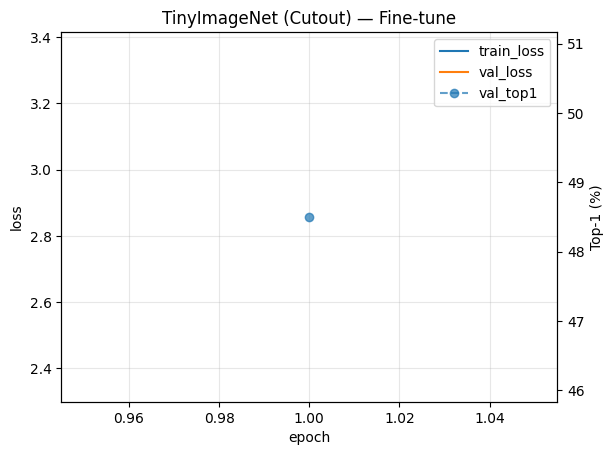


--- Test ---
TinyImageNet (Cutout) Test — loss=2.3501  top1=48.50%  top5=75.98%
Computing confusion matrix on test set...
Confusion matrix complete.


In [ ]:
tiny_cutout = run_experiment(
    "TinyImageNet (Cutout)",
    build_tinyimagenet_loaders,
    aug_mode="cutout",
    num_classes=200,
    cfg=CONFIG,
    ckpt_path=CKPT_DIR / "tiny_lp.pt"
)

## MixUp


--- Dataset stats ---
{'train': 100000, 'val': 5000, 'test': 5000}

--- Build model ---
Model built: ResNet-18 -> 200 classes

--- Fine-tune ---


/tmp/ipython-input-2634277791.py:20: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(amp and device.type == "cuda"))


[FT] epoch 01  train_loss=4.0275  val_loss=2.6638  top1=43.68%  top5=71.30%


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

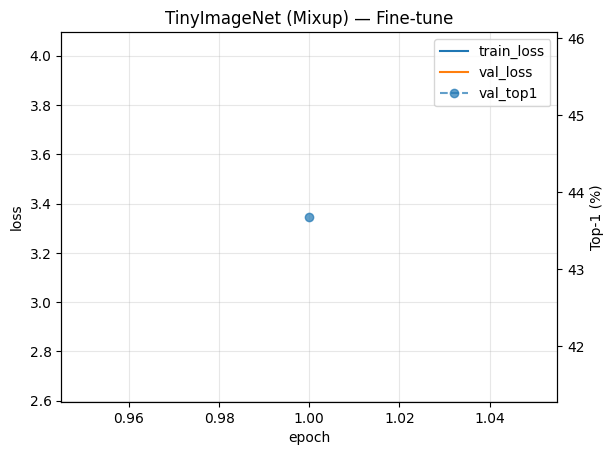


--- Test ---
TinyImageNet (Mixup) Test — loss=2.6638  top1=43.68%  top5=71.30%
Computing confusion matrix on test set...
Confusion matrix complete.


In [ ]:
tiny_mixup = run_experiment("TinyImageNet (Mixup)",
                                build_tinyimagenet_loaders,
                                aug_mode="mixup",
                                num_classes=200,
                                cfg=CONFIG,
                                ckpt_path=CKPT_DIR / "tiny_lp.pt")

## CutMix


--- Dataset stats ---
{'train': 100000, 'val': 5000, 'test': 5000}

--- Build model ---
Model built: ResNet-18 -> 200 classes

--- Fine-tune ---


/tmp/ipython-input-2634277791.py:20: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(amp and device.type == "cuda"))


[FT] epoch 01  train_loss=4.1191  val_loss=2.6106  top1=44.90%  top5=72.74%


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

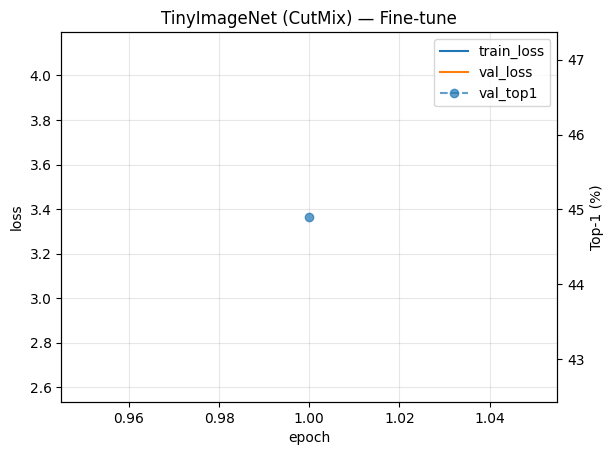


--- Test ---
TinyImageNet (CutMix) Test — loss=2.6106  top1=44.90%  top5=72.74%
Computing confusion matrix on test set...
Confusion matrix complete.


In [ ]:
tiny_cutmix = run_experiment("TinyImageNet (CutMix)",
                                 build_tinyimagenet_loaders,
                                 aug_mode="cutmix",
                                 num_classes=200,
                                 cfg=CONFIG,
                                 ckpt_path=CKPT_DIR / "tiny_lp.pt")

In [ ]:
print(cifar_baseline)

{'name': 'CIFAR100 (Baseline)', 'sizes': {'train': 45000, 'val': 5000, 'test': 10000}, 'ft_history': {'train_loss': [2.9263908570183648], 'val_loss': [2.312844887161255], 'val_top1': [46.74], 'val_top5': [78.26], 'lr': [[0.0, 0.0]]}, 'test_metrics': {'loss': 2.346464671707153, 'top1': 46.36, 'top5': 77.55}, 'cm': array([[77,  1,  0, ...,  0,  0,  0],
       [ 0, 54,  0, ...,  0,  0,  3],
       [ 0,  2, 35, ...,  0,  3,  0],
       ...,
       [ 0,  1,  0, ..., 57,  0,  0],
       [ 0,  0,  2, ...,  0, 22,  0],
       [ 0,  0,  0, ...,  0,  0, 72]])}


# Comparison

,Model,LP epochs,FT epochs,Best Val Top-1 (%),Best Val Top-5 (%),Best phase@epoch,Test Top-1 (%),Test Top-5 (%),Test loss,Train time (min)
0,ResNet-18,0,1,46.74,78.26,FT@1,46.36,77.55,2.3465,—
1,+ Mixup,0,1,40.26,72.00,FT@1,39.53,71.39,2.6253,—
2,+ Cutout,0,1,42.66,74.56,FT@1,42.39,74.61,2.4918,—
3,+ CutMix,0,1,39.50,72.18,FT@1,39.26,71.98,2.6575,—


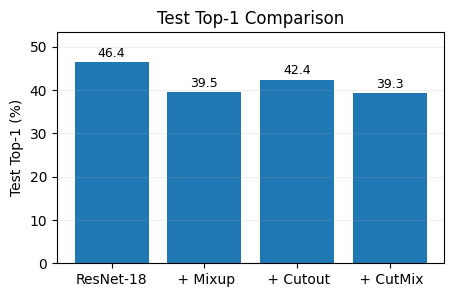

,Model,LP epochs,FT epochs,Best Val Top-1 (%),Best Val Top-5 (%),Best phase@epoch,Test Top-1 (%),Test Top-5 (%),Test loss,Train time (min)
0,Tiny ImageNet,0,1,50.34,77.48,FT@1,50.34,77.48,2.2921,—
1,+ Mixup,0,1,43.68,71.30,FT@1,43.68,71.30,2.6638,—
2,+ Cutout,0,1,48.50,75.98,FT@1,48.50,75.98,2.3501,—
3,+ CutMix,0,1,44.90,72.74,FT@1,44.90,72.74,2.6106,—


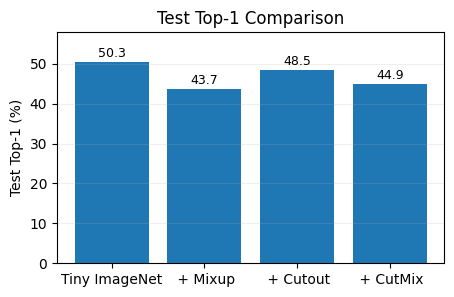

In [ ]:

# Build a compact table of key metrics and a tiny bar chart for Test Top-1.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def _best_from_history(hist: dict):
    """Return (best_top1, best_top5, best_epoch_idx) from a history dict, or (nan, nan, -1)."""
    v1 = hist.get("val_top1", []) or []
    v5 = hist.get("val_top5", []) or []
    if len(v1) == 0:
        return np.nan, np.nan, -1
    idx = int(np.nanargmax(np.asarray(v1, dtype=float)))
    best1 = float(v1[idx])
    best5 = float(v5[idx]) if idx < len(v5) and v5[idx] is not None else np.nan
    return best1, best5, idx + 1  # 1-based epoch index

def summarize_results(name: str, res: dict):
    """Extract summary stats from a run_experiment() result dict."""
    lp_hist = res.get("lp_history", {}) or {}
    ft_hist = res.get("ft_history", {}) or {}
    test   = res.get("test_metrics", {}) or {}

    # Epoch counts inferred from histories
    lp_epochs = len(lp_hist.get("val_top1", []) or [])
    ft_epochs = len(ft_hist.get("val_top1", []) or [])

    # Best validation metrics across both phases
    lp_best1, lp_best5, lp_best_ep = _best_from_history(lp_hist)
    ft_best1, ft_best5, ft_best_ep = _best_from_history(ft_hist)

    if np.isnan(lp_best1) and not np.isnan(ft_best1):
        best_val_top1, best_val_top5, best_phase, best_epoch = ft_best1, ft_best5, "FT", ft_best_ep
    elif np.isnan(ft_best1) and not np.isnan(lp_best1):
        best_val_top1, best_val_top5, best_phase, best_epoch = lp_best1, lp_best5, "LP", lp_best_ep
    else:
        # choose the higher top-1; tie-breaker prefers FT
        if ft_best1 >= (lp_best1 if not np.isnan(lp_best1) else -np.inf):
            best_val_top1, best_val_top5, best_phase, best_epoch = ft_best1, ft_best5, "FT", ft_best_ep
        else:
            best_val_top1, best_val_top5, best_phase, best_epoch = lp_best1, lp_best5, "LP", lp_best_ep

    # Test metrics
    test_top1 = float(test.get("top1", np.nan))
    test_top5 = float(test.get("top5", np.nan))
    test_loss = float(test.get("loss", np.nan))

    # Optional training time if available in results; otherwise NaN
    train_time_min = float(res.get("train_time_min", np.nan))

    return {
        "Model": name,
        "LP epochs": lp_epochs,
        "FT epochs": ft_epochs,
        "Best Val Top-1 (%)": round(best_val_top1, 2) if not np.isnan(best_val_top1) else np.nan,
        "Best Val Top-5 (%)": round(best_val_top5, 2) if not np.isnan(best_val_top5) else np.nan,
        "Best phase@epoch": f"{best_phase}@{best_epoch}" if best_epoch != -1 else "—",
        "Test Top-1 (%)": round(test_top1, 2) if not np.isnan(test_top1) else np.nan,
        "Test Top-5 (%)": round(test_top5, 2) if not np.isnan(test_top5) else np.nan,
        "Test loss": round(test_loss, 4) if not np.isnan(test_loss) else np.nan,
        "Train time (min)": round(train_time_min, 1) if not np.isnan(train_time_min) else "—",
    }

# Collect available results; adjust the list below to include your runs
cifar_results = []
if "cifar_baseline" in globals(): cifar_results.append(summarize_results("ResNet-18", cifar_baseline))
if "cifar_mixup"  in globals(): cifar_results.append(summarize_results(" + Mixup", cifar_mixup))
if "cifar_cutout"  in globals(): cifar_results.append(summarize_results(" + Cutout", cifar_cutout))
if "cifar_cutmix"  in globals(): cifar_results.append(summarize_results(" + CutMix", cifar_cutmix))

tiny_results = []
if "tiny_baseline"  in globals(): tiny_results.append(summarize_results("Tiny ImageNet", tiny_baseline))
if "tiny_mixup"  in globals(): tiny_results.append(summarize_results(" + Mixup", tiny_mixup))
if "tiny_cutout"  in globals(): tiny_results.append(summarize_results(" + Cutout", tiny_cutout))
if "tiny_cutmix"  in globals(): tiny_results.append(summarize_results(" + CutMix", tiny_cutmix))

# Create DataFrames
cifar_df = pd.DataFrame(cifar_results, columns=[
    "Model", "LP epochs", "FT epochs",
    "Best Val Top-1 (%)", "Best Val Top-5 (%)", "Best phase@epoch",
    "Test Top-1 (%)", "Test Top-5 (%)", "Test loss",
    "Train time (min)"
])
tiny_df = pd.DataFrame(tiny_results, columns=[
    "Model", "LP epochs", "FT epochs",
    "Best Val Top-1 (%)", "Best Val Top-5 (%)", "Best phase@epoch",
    "Test Top-1 (%)", "Test Top-5 (%)", "Test loss",
    "Train time (min)"
])

# Show table
from IPython.display import display

def show_table(df):
  display(df)

  # Tiny bar chart for Test Top-1
  plt.figure(figsize=(5, 3))
  labels = df["Model"].tolist()
  values = df["Test Top-1 (%)"].astype(float).tolist()
  plt.bar(labels, values)
  plt.ylabel("Test Top-1 (%)")
  plt.title("Test Top-1 Comparison")
  for i, v in enumerate(values):
      plt.text(i, v + 0.5, f"{v:.1f}", ha="center", va="bottom", fontsize=9)
  plt.ylim(0, max(values + [0]) * 1.15 if values else 1)
  plt.grid(axis="y", alpha=0.2)
  plt.show()

show_table(cifar_df)
show_table(tiny_df)

# Create Figures

## Data Augmentation Examples

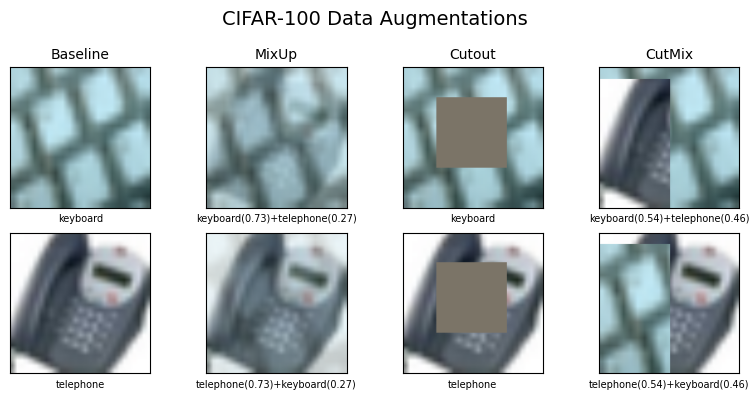

In [ ]:
# === Create Figures for Report / Poster ===
# Assumes you have already run:
#   - run_and_save_linear_probe(...)
#   - res_cifar_baseline, res_cifar_cutout, res_cifar_mixup, res_cifar_cutmix
#   - res_tiny_baseline,  res_tiny_cutout,  res_tiny_mixup,  res_tiny_cutmix
#
# This cell creates:
#   (A) Augmentation examples + labels (CIFAR-100)
#   (B) Linear probe histories (CIFAR-100 + Tiny ImageNet)
#   (C) Fine-tuning histories (CIFAR-100 + Tiny ImageNet)

import numpy as np
import matplotlib.pyplot as plt
import torch

set_seed(3)
# ---------- Helper: apply batch-level augmentation then denorm ----------

def apply_batch_aug(x, y, num_classes, mode: str):
    """
    x: [B,3,H,W] normalized to ImageNet stats
    y: [B] hard labels (int)
    mode: 'baseline' | 'cutout' | 'mixup' | 'cutmix'
    Returns (x_aug, y_aug) where y_aug may be hard or soft labels.
    """
    mode = mode.lower()
    if mode == "baseline":
        return x.clone(), y.clone()

    batch_aug = make_batch_aug(num_classes=num_classes, mode=mode, p=1.0)
    x_aug, y_aug = batch_aug(x.clone(), y.clone())
    return x_aug, y_aug

def _denorm(x, mean=IMAGENET_MEAN, std=IMAGENET_STD):
    """Invert normalization: x := x*std + mean, then clamp to [0,1]. Works for [B,3,H,W] or [3,H,W]."""
    if mean is None or std is None:
        return x
    if x.dim() == 4:
        m = torch.tensor(mean, device=x.device).view(1, -1, 1, 1)
        s = torch.tensor(std,  device=x.device).view(1, -1, 1, 1)
    else:
        m = torch.tensor(mean, device=x.device).view(-1, 1, 1)
        s = torch.tensor(std,  device=x.device).view(-1, 1, 1)
    return (x * s + m).clamp(0, 1)

def denorm_batch(x):
    """
    x: [B,3,H,W] normalized to ImageNet stats -> return [B,H,W,3] in [0,1] for plotting.
    """
    x = _denorm(x, mean=IMAGENET_MEAN, std=IMAGENET_STD)
    x = x.clamp(0, 1)
    return x.permute(0, 2, 3, 1).cpu().numpy()


def format_soft_label(probs, class_names, topk=2):
    """
    probs: [num_classes] tensor of soft labels.
    Returns a short string like 'fox(0.6)+truck(0.4)'.
    """
    probs = probs.detach().cpu()
    vals, idx = torch.topk(probs, k=topk)
    parts = []
    for v, i in zip(vals, idx):
        parts.append(f"{class_names[int(i)]}({v.item():.2f})")
    return "+".join(parts)


# ======================================================================
# (A) FIGURE: Augmentation examples + labels (CIFAR-100)
# ======================================================================

# Build a small CIFAR-100 train loader (reuses CONFIG / DATA_DIR)
cifar_train_loader, _, _, cifar_classes = build_cifar100_loaders(CONFIG, root=DATA_DIR)

# Take one batch
x_batch, y_batch = next(iter(cifar_train_loader))   # x normalized, y hard labels
x_batch = x_batch.to("cpu")
y_batch = y_batch.to("cpu")

# Use first 2 examples for a compact grid
n_show = 2
x_batch = x_batch[:n_show]
y_batch = y_batch[:n_show]

modes = [
    ("Baseline", "baseline"),
    ("MixUp",    "mixup"),
    ("Cutout",   "cutout"),
    ("CutMix",   "cutmix"),
]

# Precompute augmented batches for each mode
aug_data = []
for aug_name, mode in modes:
    x_aug, y_aug = apply_batch_aug(x_batch, y_batch, num_classes=100, mode=mode)
    x_imgs = denorm_batch(x_aug)

    if not isinstance(y_aug, torch.Tensor):
        y_aug = torch.as_tensor(y_aug)

    aug_data.append((aug_name, x_imgs, y_aug))

# Now: rows = examples, cols = augmentations
fig, axes = plt.subplots(n_show, len(modes),
                         figsize=(2.0 * len(modes), 2.0 * n_show))

for row in range(n_show):  # each example
    for col, (aug_name, x_imgs, y_aug) in enumerate(aug_data):  # each augmentation
        ax = axes[row, col] if n_show > 1 else axes[col]
        ax.imshow(x_imgs[row])
        ax.set_xticks([])
        ax.set_yticks([])

        # Column titles: augmentation names
        if row == 0:
            ax.set_title(aug_name, fontsize=10)

        # Build a short label string for THIS image under THIS aug
        if y_aug.ndim == 1:   # hard labels
            cls_idx = int(y_aug[row].item())
            label_str = cifar_classes[cls_idx]
        else:                 # soft labels (MixUp / CutMix)
            label_str = format_soft_label(y_aug[row], cifar_classes, topk=2)

        # Put the label under the image
        ax.set_xlabel(label_str, fontsize=7)

fig.suptitle("CIFAR-100 Data Augmentations", fontsize=14)
plt.tight_layout()
plt.savefig("fig_augmentations_cifar100.png", dpi=300, bbox_inches="tight")
plt.show()


## Training History

/tmp/ipython-input-2123784482.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


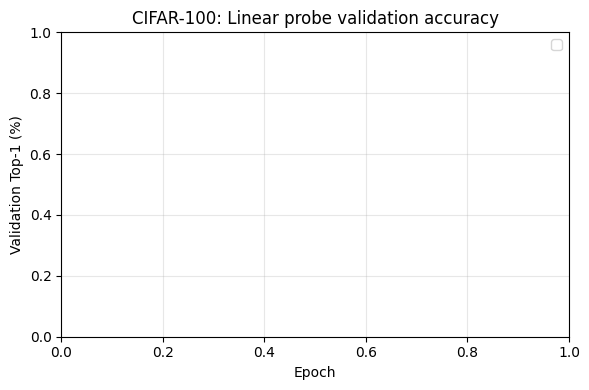

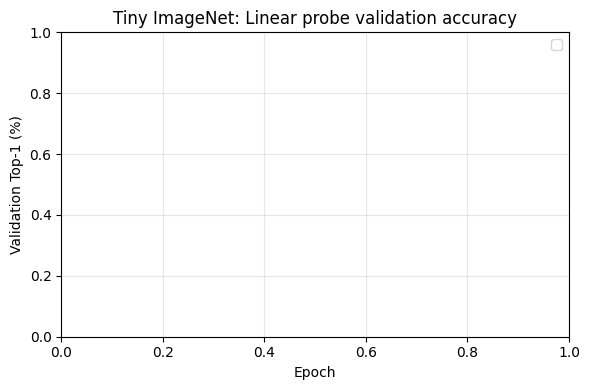

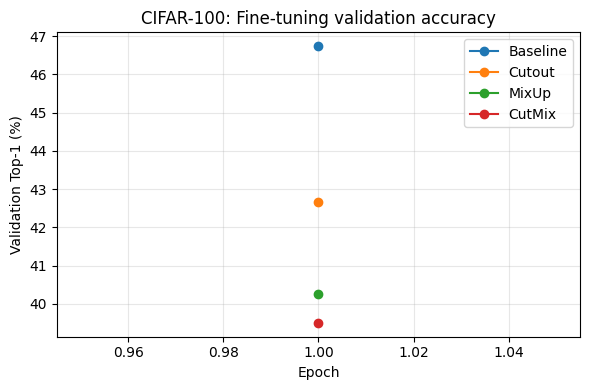

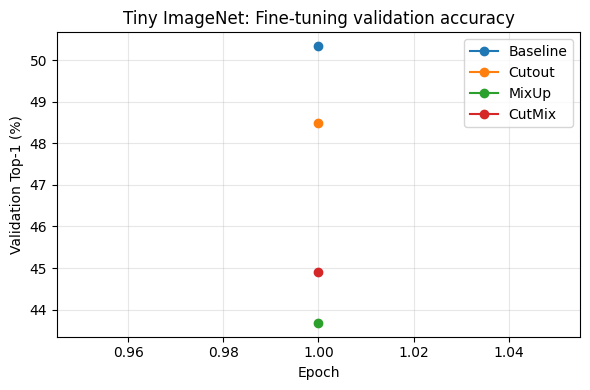

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# ======================================================================
# (B) FIGURE: Linear probe histories (val Top-1 vs epoch)
# ======================================================================

def plot_phase_histories(dataset_name, results_dict, phase_key="lp_history",
                         filename="fig_lp_histories.png"):
    """
    dataset_name: string ("CIFAR-100", "Tiny ImageNet")
    results_dict: {label: res_dict} where res_dict comes from run_experiment()
    phase_key: 'lp_history' or 'ft_history'
    """
    plt.figure(figsize=(6, 4))
    for label, res in results_dict.items():
        if res is None:
            continue
        hist = res.get(phase_key, {}) or {}
        ys = hist.get("val_top1", []) or []
        if len(ys) == 0:
            continue
        xs = np.arange(1, len(ys) + 1)
        plt.plot(xs, ys, marker="o", label=label)
    plt.xlabel("Epoch")
    plt.ylabel("Validation Top-1 (%)")
    plt.title(f"{dataset_name}: {('Linear probe' if phase_key=='lp_history' else 'Fine-tuning')} validation accuracy")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()


# CIFAR-100 linear probe histories
cifar_results_lp = {
    "Baseline": cifar_baseline,
    "Cutout":   cifar_cutout,
    "MixUp":    cifar_mixup,
    "CutMix":   cifar_cutmix,
}
plot_phase_histories("CIFAR-100", cifar_results_lp,
                     phase_key="lp_history",
                     filename="fig_lp_histories_cifar100.png")

# Tiny ImageNet linear probe histories (if available)
tiny_results_lp = {
    "Baseline": tiny_baseline,
    "Cutout":   tiny_cutout,
    "MixUp":    tiny_mixup,
    "CutMix":   tiny_cutmix,
}
plot_phase_histories("Tiny ImageNet", tiny_results_lp,
                      phase_key="lp_history",
                      filename="fig_lp_histories_tiny.png")


# ======================================================================
# (C) FIGURE: Fine-tuning histories (val Top-1 vs epoch)
# ======================================================================

# CIFAR-100 fine-tuning histories
plot_phase_histories("CIFAR-100", cifar_results_lp,
                     phase_key="ft_history",
                     filename="fig_ft_histories_cifar100.png")

plot_phase_histories("Tiny ImageNet", tiny_results_lp,
                      phase_key="ft_history",
                      filename="fig_ft_histories_tiny.png")